# CH7 Exercises


8. Load the MNIST dataset (introduced in Chapter 3), and split it into a training
   set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000
   for validation, and 10,000 for testing). Then train various classifiers, such as a
   random forest classifier, an extra-trees classifier, and an SVM classifier. Next, try
   to combine them into an ensemble that outperforms each individual classifier
   on the validation set, using soft or hard voting. Once you have found one, try
   it on the test set. How much better does it perform compared to the individual
   classifiers?


In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

c:\Users\sayed\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X = mnist.data
X = X/255.0
y = mnist.target

In [3]:
print(type(y[0]))

<class 'str'>


In [4]:
y = y.astype(int)

In [5]:
from sklearn.model_selection import train_test_split

X_train, xtemp, y_train, y_temp = train_test_split(
    X, y, train_size=5/7, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(
    xtemp, y_temp, train_size=.5, random_state=42, stratify=y_temp)

In [6]:
X_train.shape, X_valid.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

In [7]:
y_train.shape, y_valid.shape, y_test.shape

((50000,), (10000,), (10000,))

5


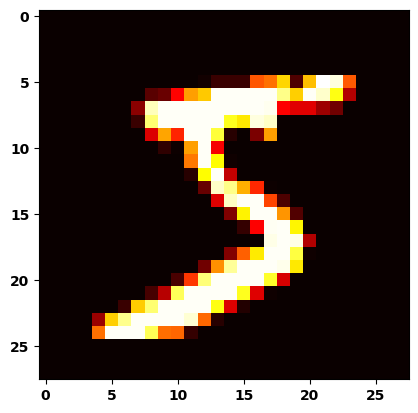

In [8]:
import matplotlib.pyplot as plt

plt.imshow((X[0]/255.0).reshape(28, 28), cmap='hot')
print(y[0])
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

models = [
    ("RandomForestClassifier", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("LogisticRegression", LogisticRegression(random_state=21, max_iter=10000)),
    ("ExtraTreesClassifier", ExtraTreesClassifier(random_state=2, n_jobs=-1))
]
for name, model in models:
    model.fit(X_train, y_train)
    print(type(model).__name__, model.score(X_valid, y_valid))

RandomForestClassifier 0.9669
LogisticRegression 0.9195
ExtraTreesClassifier 0.9697


Voting


In [10]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

voting_clf = VotingClassifier(estimators=models,
                              voting='hard')
voting_clf.fit(X_train, y_train)
print("Hard Voting Score: ", voting_clf.score(X_valid, y_valid))

Hard Voting Score:  0.9673


In [11]:
voting_clf = VotingClassifier(estimators=models,
                              voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)
print("Soft Voting Score: ", voting_clf.score(X_valid, y_valid))

Soft Voting Score:  0.952


In [12]:
voting_clf.set_params(LogisticRegression='drop')

VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('LogisticRegression', 'drop'),
                             ('ExtraTreesClassifier',
                              ExtraTreesClassifier(n_jobs=-1, random_state=2))],
                 n_jobs=-1, voting='soft')

In [13]:
logReg_trained = voting_clf.named_estimators_.pop("LogisticRegression")
voting_clf.estimators_.remove(logReg_trained)

In [14]:
print("Soft Voting Score without logistic regression: ",
      voting_clf.score(X_valid, y_valid))

Soft Voting Score without logistic regression:  0.9699


In [15]:
voting_clf.voting = 'hard'

print("hard Voting Score without logistic regression: ",
      voting_clf.score(X_valid, y_valid))

hard Voting Score without logistic regression:  0.9681


seems like we are better without logistic regression..


In [16]:
voting_clf.score(X_test, y_test)

0.9667

Stacking


In [17]:
from sklearn.neural_network import MLPClassifier

In [18]:
stacking_clf = StackingClassifier(estimators=models, final_estimator=MLPClassifier(random_state=3),
                                  n_jobs=-1)

stacking_clf.fit(X_train, y_train)
print(stacking_clf.score(X_valid, y_valid))

0.9748


c:\Users\sayed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
stacking_clf.score(X_test, y_test)

0.9757

9. Run the individual classifiers from the previous exercise to make predictions on
   the validation set, and create a new training set with the resulting predictions:
   each training instance is a vector containing the set of predictions from all your
   classifiers for an image, and the target is the image’s class. Train a classifier
   on this new training set. Congratulations—you have just trained a blender, and
   together with the classifiers it forms a stacking ensemble! Now evaluate the
   ensemble on the test set. For each image in the test set, make predictions with all
   your classifiers, then feed the predictions to the blender to get the ensemble’s pre‐
   dictions. How does it compare to the voting classifier you trained earlier? Now
   try again using a StackingClassifier instead. Do you get better performance? If
   so, why?


In [20]:
import pandas as pd
model_preds = pd.DataFrame()

model_preds['Target'] = y_valid

for name, m in models:
    model_preds[name] = m.predict(X_valid)

In [21]:
model_preds

,Target,RandomForestClassifier,LogisticRegression,ExtraTreesClassifier
0,1,1,1,1
1,8,8,8,8
2,3,5,3,5
3,0,0,0,0
4,1,1,1,1
...,...,...,...,...
9995,3,3,3,3
9996,2,2,2,2
9997,8,9,5,9
9998,6,6,6,6


In [22]:
mlp = MLPClassifier(random_state=32, max_iter=10_000)
mlp.fit(model_preds.drop(columns=['Target']), model_preds['Target'])

MLPClassifier(max_iter=10000, random_state=32)

Evaluating on test set:


In [23]:
new = pd.DataFrame()
new['Target'] = y_test
for name, m in models:
    new[name] = m.predict(X_test)

print(mlp.score(new.drop(columns=['Target']), y_test))

0.9657


the `Stacking Classifier` outperforms the one we created due to cross-validation technique it uses, and using predict_proba if available which will give the model much more nuanced inputs to work with.
